# Week 6 - Ensembles

In the previous two weeks you learned about (deep) neural networks, which are the state of the art approach to most unstructured (image, text, etc.) data problems. For structured (i.e. tabular numerical data), ensembles of simpler models also tend to work well.

Today you will be introduced to applications of:

* Decision Trees (Chapter 8 of An Introduction to Statistical Learning of James *et al.*)
* Bagging (Chapter 8 of An Introduction to Statistical Learning of James *et al.*)
* Boosting (Section 14.3 of Bishop)

### First, for both Windows & MacOS, please install `graphviz`  from command/terminal prompt:
- `pip install graphviz`

### Then for MacOS, please execture the following  from command/terminal prompt:
- `conda install graphviz`

### Or for windows: 
- you have to install the graphviz-executables: [graphviz.gitlab.io/_pages/Download/Download_windows.html/](https://graphviz.gitlab.io/_pages/Download/Download_windows.html) (select `msi`-file and execute) and add the installation folder to your PATH-environment

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
from sklearn import tree

import graphviz 

# Toy Data

In [2]:
# Create the dataset
N=100
rng = np.random.RandomState(1)
x = np.linspace(0, 6, N)[:, np.newaxis]
t = np.sin(x) + np.sin(6 * x) + rng.normal(0, 0.1, (N,1))

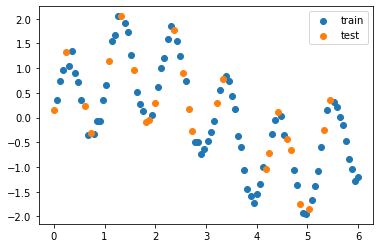

In [3]:
# train test split
x_train, x_test, t_train, t_test = sklearn.model_selection.train_test_split(x,t,random_state=42)

# plot whole dataset
plt.scatter(x_train,t_train,label='train')
plt.scatter(x_test,t_test,label='test')
plt.legend()

# Decision Tree

In Chapter 8 of An Introduction to Statistical Learning of James *et al.* you have learned about decision trees. They apply a *greedy* algorithm to split the data in such a way that maximally reduces the *mean square error* at every split point. This continues until the *minimum samples per leaf node* or a *maximum tree detph* is reached. Afterwards the decision tree is *pruned*, by removing the leaf nodes which do not improve the model enough compared some regularization parameter.

Note: pruning is currently not supported in sklearn

In [4]:
# specify a model
dtr = sklearn.tree.DecisionTreeRegressor(
    criterion='mse',       # loss function
    min_samples_leaf=1,    # hyper parameter
    max_depth=2)           # hyper parameter

In [5]:
# fit
dtr.fit(x_train,t_train)
# score
print('train score: {:.2f}'.format(dtr.score(x_train,t_train)))
print('test score: {:.2f}'.format(dtr.score(x_test,t_test)))

train score: 0.65
test score: 0.39


In [6]:
# visualize tree
dot_data = tree.export_graphviz(dtr, out_file=None, 
                        feature_names=['x'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("test") 
graph

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'test'], make sure the Graphviz executables are on your systems' PATH

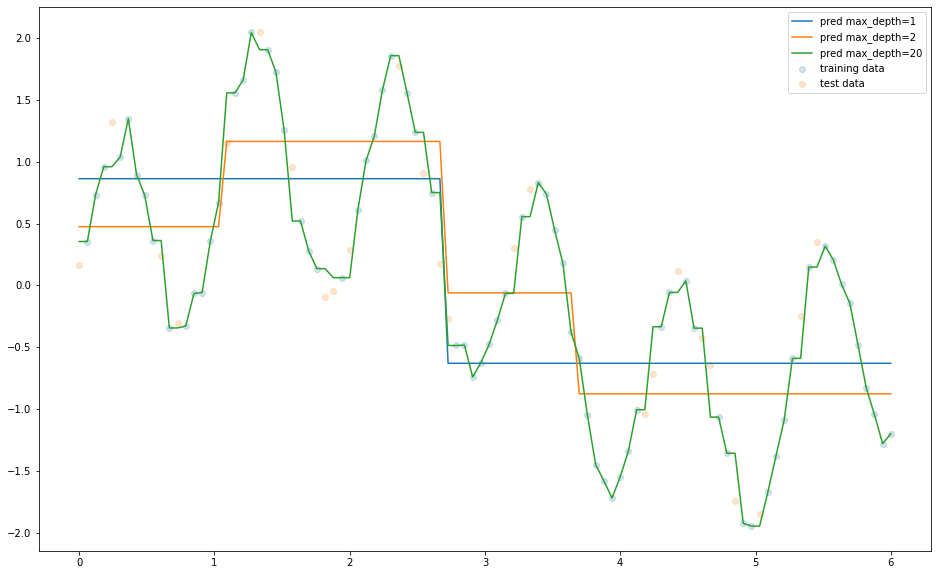

In [7]:
# visualize trees of different depth

# plot whole dataset
plt.figure(figsize=(16,10))
plt.scatter(x_train,t_train,label='training data',alpha=0.2)
plt.scatter(x_test,t_test,label='test data',alpha=0.2)

# make pred lines for different depth
for m in [1,2,20]:
    dtr = sklearn.tree.DecisionTreeRegressor(max_depth=m).fit(x_train,t_train)
    y = dtr.predict(x)
    plt.plot(x,y,label=f'pred max_depth={m}')
    
# finalize plot|
plt.legend()

**@Quick question:**

**What is the maximum different predictive values when `max_depth=1`? What is the maximum different predictive values when `max_depth=2`? What is the maximum different predictive values when `max_depth=m`?**

*Answer here*
For `max_depth=1` there are only 2 different predictive values.<BR>
For `max_depth=2` there are only max. 4 different predictive values.<BR>
For `max_depth=m` there are only max. $2^m$ different predictive values.<BR>


# A real dataset

To explore today's data we will look at the Boston housing dataset from sklearn. You can read more about this dataset [here](https://www.cs.toronto.edu/%7Edelve/data/boston/bostonDetail.html)

In [8]:
boston = sklearn.datasets.load_boston()

In [9]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
# make into dataframe
X = pd.DataFrame(boston.data, columns=boston.feature_names)
t = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(X,t,random_state=42)

In [11]:
# print top 3 rows
X.head(3).T

,0,1,2
CRIM,0.00632,0.02731,0.02729
ZN,18.00000,0.00000,0.00000
INDUS,2.31000,7.07000,7.07000
CHAS,0.00000,0.00000,0.00000
NOX,0.53800,0.46900,0.46900
RM,6.57500,6.42100,7.18500
AGE,65.20000,78.90000,61.10000
DIS,4.09000,4.96710,4.96710
RAD,1.00000,2.00000,2.00000
TAX,296.00000,242.00000,242.00000


In [15]:
t_train

,MEDV
182,37.9
155,15.6
280,45.4
126,15.7
329,22.6
...,...
106,19.5
270,21.1
348,24.5
435,13.4


# Bagging / Random Forests

Now we will discuss a form of ensemble or committee models: *bagging* or *Bootstrap AGGregating*. You have read in Section 8.2 of *An Introduction to Statistical Learning* (or Section 14.2 of Bishop) how the error of the average predictions is less than the average error of the individual models. You have also read that the extent to which this process can reduce the error depends negatively on the correlation between the models.

Thus we need to balance to concerns:

* Reduce the error of the individual models
* Avoid correlation of predictions of the individual models

We will now explore this issue in the context of decision trees.

To decorrelate the predictions we have two main tricks:

* Train models on subsets of the data (this is the actual bagging step)
* Train models on subsets of the features (this is another separate trick)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# sample starter code
rf = RandomForestRegressor(
    n_estimators=10,     # how many trees to estimate
    bootstrap=True,      
    max_features='auto', # how many features to consider at each split
    criterion='mse',
    max_depth=None, 
    min_samples_leaf=1, 
    n_jobs=-1,           # use 1 core, some, or all (-1)
    random_state=42,
)

Let's fit a random forest to the data and calculate the MSE using `sklearn.metrics`

In [ ]:
rf.fit(X_train, t_train.values.ravel())
t_pred=rf.predict(X_test)
MSE=mean_squared_error(t_test.values.ravel(),t_pred)
print(MSE)

Can we say anything about the importance of the variables? Yes, we can!

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

Let's initialize a grid of parameters over which to search the optimum

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 60, 80, 100],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 4],
    'n_estimators': [200, 500, 1000]
}

# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)

The cell below performs the grid search over 48 configurations:
$4 \times 2 \times  2 \times 3 \times = 48$<BR>
The output shows the optimal parameters.<BR>
Note: this could take some time (a few minutes max).
    
**@Question:**

**Why are there 144 fits necessary?**

*Answer here*
Since we use 3-fold CV, the 48 configurations have to be fitted 3*48=144 times

In [ ]:
rf_grid.fit(X_train, t_train.values.ravel())
print(rf_grid.best_params_)

`rf_grid.best_estimator_` denotes the optimal random forest, while `dtr=rf_grid.best_estimator_.estimators_[0]` denotes the first decision tree of this forest.<BR>
    
**@Exercises:**

**Determine the MSE of the optimal random forest**

In [ ]:
t_pred=rf_grid.best_estimator_.predict(X_test)
MSE=mean_squared_error(t_test.values.ravel(),t_pred)
print(MSE)

**@Exercises:**

**Construct a graph of the first tree of the optimal random forest**

In [ ]:
dtr=rf_grid.best_estimator_.estimators_[0]
dot_data = tree.export_graphviz(dtr, out_file=None,
                                feature_names=boston.feature_names,filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("test") 
graph

**@Questions**

**1. Can increasing n_estimators reduce accuracy on the train/test error? How would you set it?**

*Answer here*
Increasing n_estimators cannot reduce performance. However, as n_estimators increases the correlation between the models will increase. Hence the improvement relative to those individual models will decrease. However since we're only concerned in the absolute performance of the final model we don't care about that. In the end we want to estimate as many decision trees as feasible.

**2. What is the size of each bootstrap sample?**

*Answer here*
Each bootstrap sample has a size equal to the original dataset

**3. Why would we want to sample only a subset of features, rather than use all features, for each model?**

*Answer here*
This further decorrelates the predictions of the individual models

**4. Go through the sklearn documentation. Does the subset of features get determined for each subsample or at each split? Why is this the best way?**

*Answer here*
It is determined at each split. This is the best way, because then different models make different splits at the beginning. Those splits have most impact on the model and thus decorrelate the predictions. However, it's not so bad if further down the tree dominant features of other trees make an appearance.

**5. Does your final model end up with many shallow or deep trees? Did you expect that? Why?**

*Answer here*
Random forests perform better when the individual decision trees are deep. The reason is that we want a low bias and use the random forest algorithm to reduce the variance.

# AdaBoost

A different form of committee models are *Boosting* algorithms. There are two types: *gradient* and *adaptive* boosting. Today we will look at the second, also called *AdaBoost*, discussed in Bishop Section 14.3

In [ ]:
# starter code
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# simple fit
AdaB = AdaBoostRegressor(
    base_estimator = DecisionTreeRegressor(),
    n_estimators=50, 
    learning_rate=1.0,
)
AdaB.fit(X_train,t_train.values.ravel())

# sample param_grid for gridsearch later
# note the base_estimator__ to tune the decision tree hyper parameters
param_grid = {
    "base_estimator__max_depth" : [1,2,5,None],
    "n_estimators": [1,2,10,20,50],
}

**@Questions:**

**1. Can increasing n_estimators reduce accuracy on the train/test error? How would you set it?**

*Answer here*
Increasing n_estimators can reduce performance, because it will keep reducing the error on the training set. Hence in the limit it will perfectly fit the training set and (potentially) overfit on the test set.

**2. Go through the sklearn documentation. What does the learning rate do?**

*Answer here*
It sequentially reduces the weight of the next estimator for the total prediction. This can help against overfitting.

**@Exercise**

**Compute the MSE of the AdaBoost algorithm as fitted above.**

In [ ]:
t_pred=AdaB.predict(X_test)
MSE=mean_squared_error(t_test.values.ravel(),t_pred)
print(MSE)

**@Exercise**

**Try to estimate the best possible model with GridSearchCV (an sklearn function). What's your MSE on the test set?**

Note: use `estimator = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())` for `GridSearchCV()`

In [ ]:
AdaB_grid = GridSearchCV(estimator = AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 5)
AdaB_grid.fit(X_train, t_train.values.ravel())
print(AdaB_grid.best_params_)

In [ ]:
t_pred=AdaB_grid.best_estimator_.predict(X_test)
MSE=mean_squared_error(t_test.values.ravel(),t_pred)
print(MSE)

**@Question:**

Does your final model end up with many shallow or deep trees? Did you expect that? Why?**

*Answer here*
Boosting algorithms perform better when the individual estimators are *weak learners*, or decision trees with a low depth(e.g. 1). The reason is that the boosting algorithm is more efficient at reducing the overall loss by reweighting.


# Conclusion

Today you have used in practice:

* Decision Trees
* Random Forests (Bagging with feature sampling and Decision Trees)
* AdaBoost with Decision Trees
* GridSearchCV